# Sine-Gaussian without similarity embedding

- Does not train the similarity embedding
- Trains the flow without the frozen weights from the similarity embedding training

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using {device=}")

Using device=device(type='cpu')


In [3]:
def sine_gaussian(t, omega_0, tau, shift=0):
    t_shift = t - shift
    data = torch.exp(-1*t_shift*t_shift / tau / tau) * torch.sin(2*torch.pi*omega_0 * t_shift)
    return data

def sine_gaussian_bilby(t, omega_0, tau, shift=0):
    t_shift = t - shift
    data = np.exp(-1*t_shift*t_shift / tau / tau) * np.sin(2*np.pi*omega_0 * t_shift)
    return data

## Plot

Text(0.5, 1.0, 'Time Shifted Signal for omega_0 = 1.0, tau = 4.0')

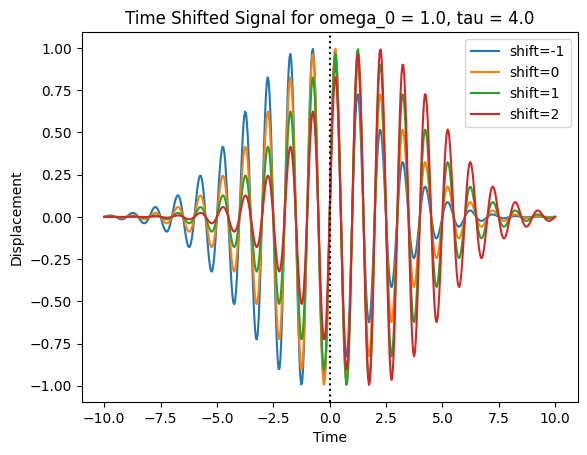

In [4]:
omega_0 = torch.tensor(1)
tau = torch.tensor(4)

t_vals = torch.linspace(-10, 10, 500)
for shift in [-1, 0, 1, 2]:
    x_vals = sine_gaussian(t_vals, omega_0=omega_0, tau=tau, shift=shift)
    plt.plot(t_vals, x_vals, label=f"{shift=}")
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.axvline(x=0, linestyle='dotted', color='black')
plt.legend()
plt.title(f"Time Shifted Signal for omega_0 = {omega_0:.1f}, tau = {tau:.1f}")

In [5]:
injection_parameters = dict(omega_0=omega_0, tau=tau, shift=4)
print(injection_parameters)

{'omega_0': tensor(1), 'tau': tensor(4), 'shift': 4}


In [6]:
num_points = 500
t_vals = np.linspace(-10, 10, num_points)

In [7]:
sigma = 0.05

In [8]:
data = sine_gaussian(t_vals, **injection_parameters) + np.random.normal(0, sigma, t_vals.size)

Text(0.5, 1.0, 'Data and Signal for Sine-Gaussian')

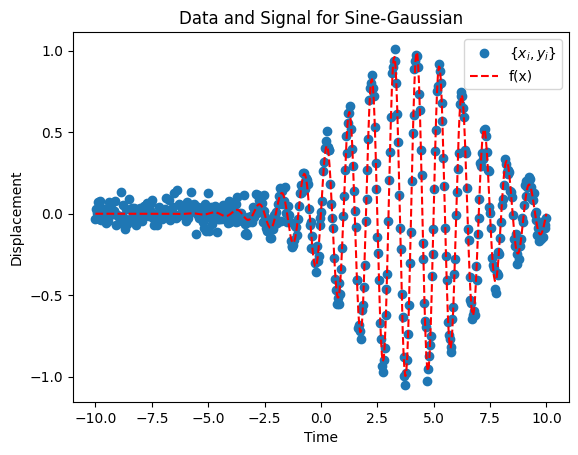

In [9]:
fig, ax = plt.subplots()
ax.plot(t_vals, data, 'o', label='$\\{x_i, y_i\\}$')
ax.plot(t_vals, sine_gaussian(t_vals, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
plt.title('Data and Signal for Sine-Gaussian')

In [10]:
import bilby
from bilby.core.prior import Uniform, DeltaFunction

## Prior for parameters

In [11]:
priors = dict()

priors['omega_0'] = Uniform(0.1, 1, name='omega_0', latex_label='$\omega_0$') #np array
priors['tau'] = Uniform(0, 4, name='tau', latex_label='$\\tau$') #np array
priors['shift'] = Uniform(-2, 2, name='shift', latex_label='$\Delta\;t$')

## Likelihood

In [12]:
from bilby.core.likelihood import GaussianLikelihood

log_l = GaussianLikelihood(t_vals, data.numpy(), sine_gaussian_bilby, sigma=sigma)

In [13]:
data.shape

torch.Size([500])

In [14]:
# result = bilby.run_sampler(
#     likelihood=log_l, priors=priors, sampler='dynesty',
#     nlive=300, npool=1, save=False, clean=True,
#     injection_parameters=injection_parameters,
#     outdir='./sine_gaussian',
#     label='sine_gaussian'
# )

In [15]:
# result.plot_corner(priors=True,levels=[0.05, 0.5, 0.95])

# Train embedding space first

The aim is to make the network be agnostic to shift in time. Train embedding space to cluster shifts in intercept value.

In [16]:
from IPython.display import clear_output
from time import sleep

In [17]:
import torch

def get_data(omega_0=None, tau=None, shift=None, num_points=1):
    """Sample omega, tau, shift and return a batch of data with noise"""
    
    omega_0 = priors['omega_0'].sample() if omega_0 is None else omega_0
    omega_0 = torch.tensor(omega_0).to(dtype=torch.float32)
    tau = priors['tau'].sample() if tau is None else tau
    tau = torch.tensor(tau).to(dtype=torch.float32)
    shift = priors['shift'].sample() if shift is None else shift
    shift = torch.tensor(shift).to(dtype=torch.float32)
    
    t_vals = torch.linspace(-1, 10, num_points).to(dtype=torch.float32) #
    
    y = sine_gaussian(t_vals, omega_0=omega_0, tau=tau, shift=shift)
    y += sigma * torch.randn(size=y.size()).to(dtype=torch.float32)
    # y = torch.from_numpy(y)
    
    return t_vals, y, omega_0, tau, shift

# Add augmentation

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

In [19]:
%%time

num_simulations = 30000
num_repeats = 50

theta_unshifted_vals = []
theta_shifted_vals = []
data_unshifted_vals = []
data_shifted_vals = []

for ii in range(num_simulations):
    # generated data with a fixed shift
    t_vals, y_unshifted, omega, tau, shift = get_data(num_points=num_points, shift=1)
    # create repeats
    theta_unshifted = torch.tensor([omega, tau, shift]).repeat(num_repeats, 1).to(device=device)
    theta_unshifted_vals.append(theta_unshifted)
    data_unshifted_vals.append(y_unshifted.repeat(num_repeats, 1).to(device=device))
    # generate shifted data
    theta_shifted = []
    data_shifted = []
    for _ in range(num_repeats):
        t_val, y_shifted, _omega, tau, shift = get_data(
            omega_0=omega, tau=tau,  # omega and tau same as above
            shift=None,
            num_points=num_points
        )
        theta_shifted.append(torch.tensor([omega, tau, shift]))
        data_shifted.append(y_shifted)
    theta_shifted_vals.append(torch.stack(theta_shifted).to(device=device))
    data_shifted_vals.append(torch.stack(data_shifted).to(device=device))

/var/folders/4z/6313y9l55p5g8j6wg77vs02h0000gn/T/ipykernel_38800/3074643031.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  omega_0 = torch.tensor(omega_0).to(dtype=torch.float32)
/var/folders/4z/6313y9l55p5g8j6wg77vs02h0000gn/T/ipykernel_38800/3074643031.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(tau).to(dtype=torch.float32)


CPU times: user 53.5 s, sys: 890 ms, total: 54.4 s
Wall time: 54.5 s


In [20]:
theta_unshifted_vals[0][:5], theta_shifted_vals[0][:5]

(tensor([[0.9705, 1.8867, 1.0000],
         [0.9705, 1.8867, 1.0000],
         [0.9705, 1.8867, 1.0000],
         [0.9705, 1.8867, 1.0000],
         [0.9705, 1.8867, 1.0000]]),
 tensor([[ 0.9705,  1.8867, -0.7504],
         [ 0.9705,  1.8867,  1.5875],
         [ 0.9705,  1.8867,  1.8917],
         [ 0.9705,  1.8867, -1.3589],
         [ 0.9705,  1.8867, -0.6001]]))

In [21]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # return shifted and unshifted theta and data
        return (
            theta_shifted_vals[idx].to(dtype=torch.float32),
            theta_unshifted_vals[idx].to(dtype=torch.float32),
            data_shifted_vals[idx].to(dtype=torch.float32),
            data_unshifted_vals[idx].to(dtype=torch.float32)
        )

In [22]:
dataset = DataGenerator()

Text(0.5, 1.0, 'Time Shifted Data for omega_0 = 0.8, tau = 3.4')

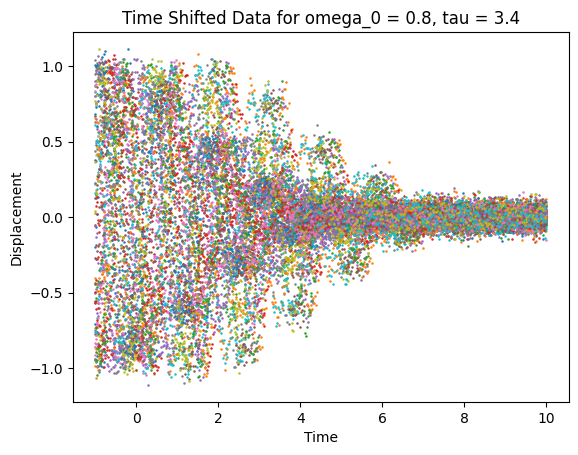

In [23]:
_, t, d, _ = dataset[4]

fig, ax = plt.subplots()

for (omega, tau, shift), points in zip(t, d):
    ax.plot(t_vals.clone().detach().cpu().numpy(), points.clone().detach().cpu().numpy(), 'o', markersize=0.8, label='$\\{x_i, y_i\\}$')
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
ax.set_title(f"Time Shifted Data for omega_0 = {t[0][0]:.1f}, tau = {t[0][1]:.1f}")
# plt.legend()

In [24]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [25]:
TRAIN_BATCH_SIZE = 400
VAL_BATCH_SIZE = 400

train_data_loader = DataLoader(
    train_data, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [26]:
for theta, _, data_aug, data_orig in train_data_loader:
    break

In [27]:
len(train_data_loader), len(val_data_loader), len(test_data_loader)

(60, 8, 3000)

In [28]:
theta.shape, data_aug.shape, data_orig.shape
#batch, chanel, dimensionality = 400, 30, 3
#400 batch size, 200 num points

(torch.Size([400, 50, 3]),
 torch.Size([400, 50, 500]),
 torch.Size([400, 50, 500]))

In [29]:
len(val_data_loader)

8

## Similarity Embedding without VICReg Loss

In [30]:
class ConvResidualBlock(nn.Module):
    def __init__(
        self,
        channels,
        kernel_size=5,
        activation=F.relu,
        dropout_probability=0.1,
        use_batch_norm=True,
        zero_initialization=True,
    ):
        super().__init__()
        self.activation = activation
        
        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.batch_norm_layers = nn.ModuleList(
                [nn.BatchNorm1d(channels, eps=1e-3) for _ in range(2)]
            )
        self.conv_layers = nn.ModuleList(
            [nn.Conv1d(channels, channels, kernel_size=kernel_size, padding='same') for _ in range(2)] #2 is for 2 conv layers
        )
        self.dropout = nn.Dropout(p=dropout_probability)
        if zero_initialization:
            nn.init.uniform_(self.conv_layers[-1].weight, -1e-3, 1e-3)
            nn.init.uniform_(self.conv_layers[-1].bias, -1e-3, 1e-3)

    def forward(self, inputs):
        temps = inputs
        if self.use_batch_norm:
            temps = self.batch_norm_layers[0](temps)
        temps = self.activation(temps)
        temps = self.conv_layers[0](temps)
        if self.use_batch_norm:
            temps = self.batch_norm_layers[1](temps)
        temps = self.activation(temps)
        temps = self.dropout(temps)
        temps = self.conv_layers[1](temps)
        return inputs + temps


class ConvResidualNet(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        hidden_channels,
        num_blocks=2,
        kernel_size=5,
        activation=F.relu,
        dropout_probability=0.1,
        use_batch_norm=True,
    ):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.initial_layer = nn.Conv1d(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            padding='same',
        )
        self.blocks = nn.ModuleList(
            [
                ConvResidualBlock(
                    channels=hidden_channels,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=use_batch_norm,
                    kernel_size=kernel_size,
                )
                for _ in range(num_blocks)
            ]
        )
        self.final_layer = nn.Conv1d(
            hidden_channels, out_channels, kernel_size=1, padding='same'
        )

    def forward(self, inputs):
        temps = self.initial_layer(inputs)
        for block in self.blocks:
            temps = block(temps)
        outputs = self.final_layer(temps)
        return outputs

In [31]:
from nflows.nn.nets.resnet import ResidualNet

num_dim=3

class SimilarityEmbedding(nn.Module):
    """Simple Dense embedding"""
    def __init__(self, num_hidden_layers_f=1, num_hidden_layers_h=1, activation=torch.tanh):
        super().__init__()
        self.num_hidden_layers_f = num_hidden_layers_f
        self.num_hidden_layers_h = num_hidden_layers_h
        
        self.layers_f = ConvResidualNet(in_channels=num_repeats, out_channels=1, hidden_channels=10, 
                                        num_blocks=1, kernel_size=5)
        self.contraction_layer = nn.Linear(500,num_dim)
        self.expander_layer = nn.Linear(num_dim,20) # 6 dimensions
        self.layers_h = nn.ModuleList([nn.Linear(20,20) for _ in range(num_hidden_layers_h)])
        self.final_layer = nn.Linear(20, 12)

        self.activation = activation

    def forward(self, x):
        x = self.layers_f(x)
        x = self.contraction_layer(x)
        representation = torch.clone(x) #copy
        x = self.activation(self.expander_layer(x))
        for layer in self.layers_h:
            x = layer(x)
            x = self.activation(x) #activation of layer(x) in layers_h
        x = self.final_layer(x)
        return x, representation

In [32]:
similarity_embedding = SimilarityEmbedding(num_hidden_layers_f=1, num_hidden_layers_h=1).to(device) #puts the neural network on the gpu


In [33]:
embed, rep = similarity_embedding(data_aug)
embed.shape, rep.shape

(torch.Size([400, 1, 12]), torch.Size([400, 1, 3]))

In [34]:
emb_aug, rep_aug = similarity_embedding(data_aug)
emb_orig, rep_orig = similarity_embedding(data_orig)

In [35]:
sum_param=0
for name, param in similarity_embedding.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.numel())
        sum_param+=param.numel()
print(sum_param)

layers_f.initial_layer.weight
2500
layers_f.initial_layer.bias
10
layers_f.blocks.0.batch_norm_layers.0.weight
10
layers_f.blocks.0.batch_norm_layers.0.bias
10
layers_f.blocks.0.batch_norm_layers.1.weight
10
layers_f.blocks.0.batch_norm_layers.1.bias
10
layers_f.blocks.0.conv_layers.0.weight
500
layers_f.blocks.0.conv_layers.0.bias
10
layers_f.blocks.0.conv_layers.1.weight
500
layers_f.blocks.0.conv_layers.1.bias
10
layers_f.final_layer.weight
10
layers_f.final_layer.bias
1
contraction_layer.weight
1500
contraction_layer.bias
3
expander_layer.weight
60
expander_layer.bias
20
layers_h.0.weight
400
layers_h.0.bias
20
final_layer.weight
240
final_layer.bias
12
5836


## See embedded space

# Varying Omega

In [36]:
# C1 orange
# C2 green
# C3 red
# C4 purple

similarity_outputs_1 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][0][0] < 0.4) and (theta_test.T[0][0][0] > 0.2)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output)
    
similarity_outputs_3 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][0][0] < 0.8) and (theta_test.T[0][0][0] > 0.6)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_3.append(similarity_output)

similarity_outputs_4 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][0][0] < 0.6) and (theta_test.T[0][0][0] > 0.4)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_4.append(similarity_output)

/var/folders/4z/6313y9l55p5g8j6wg77vs02h0000gn/T/ipykernel_38800/3577505425.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343686130/work/aten/src/ATen/native/TensorShape.cpp:3575.)
  if not ((theta_test.T[0][0][0] < 0.4) and (theta_test.T[0][0][0] > 0.2)):


In [37]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_3 = torch.stack(similarity_outputs_3)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

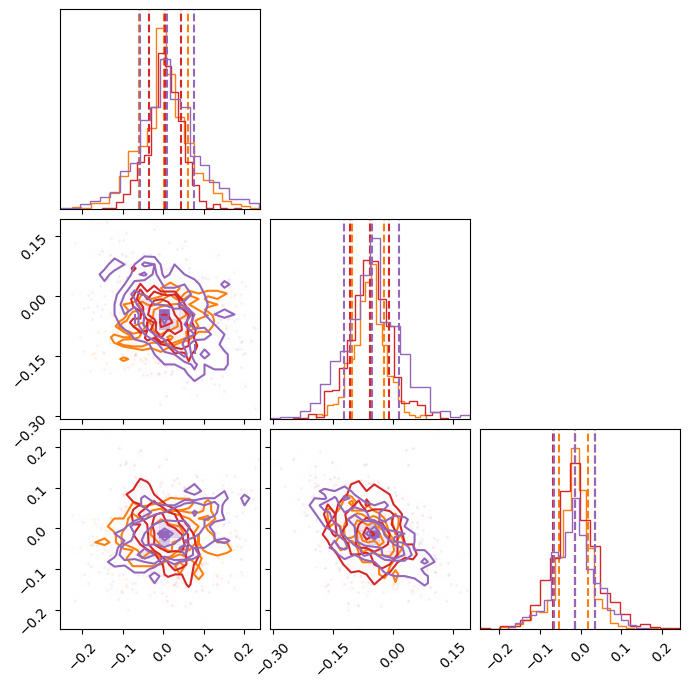

In [38]:
import corner

figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)

# Varying Tau

In [39]:
similarity_embedding.train(False)

similarity_outputs_1 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][1][0] < 0.2) and (theta_test.T[0][1][0] > 0.1)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][1][0] < 0.3) and (theta_test.T[0][1][0] > 0.2)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output)
    
similarity_outputs_3 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][1][0] < 0.4) and (theta_test.T[0][1][0] > 0.3)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_3.append(similarity_output)
    
similarity_outputs_4 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][1][0] < 0.5) and (theta_test.T[0][1][0] > 0.4)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_4.append(similarity_output)    

In [40]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_3 = torch.stack(similarity_outputs_3)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

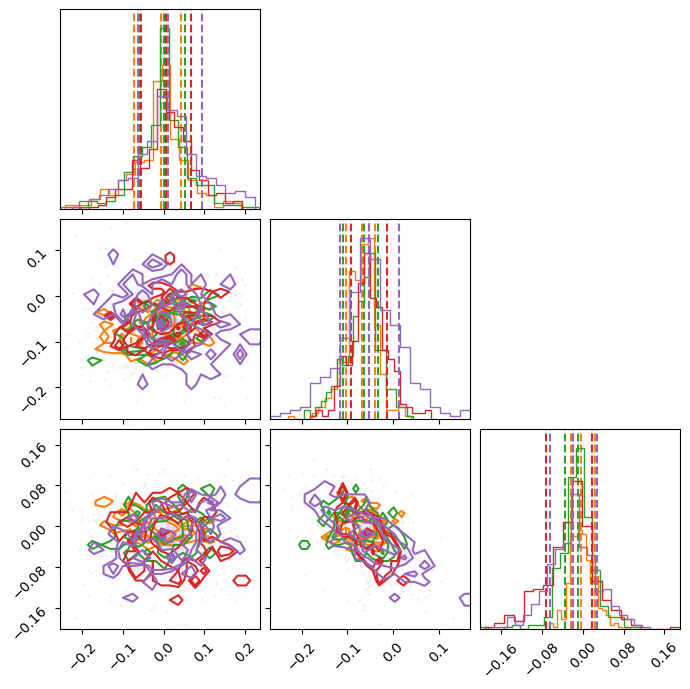

In [41]:
import corner

figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"
)

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"
)

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)

# Varying Omega with constant Tau

In [42]:
#orange green red purple

similarity_outputs_1 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test[0][0][0] < 0.75) and (theta_test[0][0][0] > 0.5) and \
            (theta_test[0][0][1] < 0.3) and (theta_test[0][0][1] > 0.2)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output)
# print(similarity_outputs_1)

similarity_outputs_2 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test[0][0][0] < 0.5) and (theta_test[0][0][0] > 0.25) and \
            (theta_test[0][0][1] < 0.2) and (theta_test[0][0][1] > 0.1)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
#         print(similarity_output.shape)
    similarity_outputs_2.append(similarity_output)
#print(similarity_outputs_2)
    
similarity_outputs_4 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test[0][0][0] < 0.5) and (theta_test[0][0][0] > 0.25) and \
            (theta_test[0][0][1] < 0.5) and (theta_test[0][0][1] > 0.4)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_4.append(similarity_output)

In [43]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

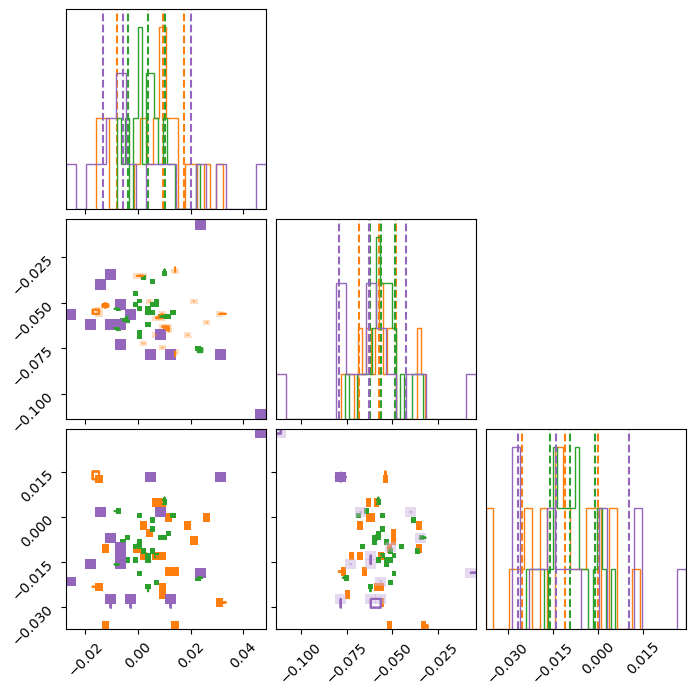

In [44]:
import corner

figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"
)

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"
)

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)

# Freeze weights, used as embedding network in MAF

In [45]:
from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation

import nflows.utils as torchutils

from nflows.transforms.autoregressive import MaskedUMNNAutoregressiveTransform
from nflows.transforms.coupling import CouplingTransform, UMNNCouplingTransform

In [46]:
class EmbeddingNet(nn.Module):
    """Wrapper around the similarity embedding defined above"""
    def forward(self, x):
        batch_size, dims = x.shape
        x = x.reshape(batch_size, 1, dims).repeat(1, num_repeats, 1)
        _, rep = similarity_embedding(x)
        return rep.reshape(batch_size, 3)

In [47]:
num_transforms = 5
num_blocks = 2
hidden_features = 10

_, rep = similarity_embedding(data_aug)
context_features = rep.shape[-1]

base_dist = StandardNormal([2])

transforms = []
for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
            features=2,  # 2-dim posterior
            hidden_features=hidden_features,
            context_features=context_features,
            num_blocks=num_blocks,
            activation=torch.tanh,
            use_batch_norm=False,
            use_residual_blocks=True,
            dropout_probability=0.01,
#             integrand_net_layers=[20, 20]
        ),
        RandomPermutation(features=2)
    ]
    transforms += block

transform = CompositeTransform(transforms)

embedding_net = EmbeddingNet()

flow = Flow(transform, base_dist, embedding_net).to(device=device)

In [48]:
# flow

In [49]:
print("Total number of trainable parameters: ", sum(p.numel() for p in flow.parameters() if p.requires_grad))

Total number of trainable parameters:  3170


# Train/Validate

In [50]:
num_augmentations = 50

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        augmented_theta, _, augmented_data, _ = val
        augmented_theta = augmented_theta[...,0:2]
        
        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:] #400,2
            data = augmented_data[:,ii,:] #400,200

            flow_loss = -flow.log_prob(theta, context=data).mean()

            optimizer.zero_grad()
            flow_loss.backward()
            optimizer.step()
            
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 10 == 0:
            last_loss = running_loss / 10 # avg loss
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Flow Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss


def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_theta, _, augmented_data, _ = val
        augmented_theta = augmented_theta[...,0:2]

        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:] #400,2
            data = augmented_data[:,ii,:] #400,200

            flow_loss = -flow.log_prob(theta, context=data).mean()
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 5 == 0:
            last_loss = running_loss / 5
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Flow Loss/val', last_loss, tb_x)

            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [51]:
optimizer = optim.Adam(flow.parameters(), lr=2e-3)

scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5)
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=2e-3)
scheduler_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

scheduler = optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 20])

In [52]:
# writer = SummaryWriter("sg_flow-no_sim_embed_train", comment="With LR=1e-3", flush_secs=5)
# epoch_number = 0

In [53]:
# %%time
# # UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
# EPOCHS = 50

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))
#     # Gradient tracking
#     flow.train(True)
#     # flow._embedding_net.train(False)
#     # no gradient tracking for embedding layer
#     for name, param in flow._embedding_net.named_parameters():
#         param.requires_grad = False

#     avg_train_loss = train_one_epoch(epoch_number, writer)

#     # no gradient tracking, for validation
#     flow.train(False)
#     avg_val_loss = val_one_epoch(epoch_number, writer)

#     print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

#     epoch_number += 1
#     scheduler.step()

In [54]:
PATH2 = './sine-gaussian-without-similarity-embedding-flow-weights.pth'
# torch.save(flow.state_dict(), PATH2)
flow.load_state_dict(torch.load(PATH2, map_location=device))
flow.eval()

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=10, bias=True)
          (context_layer): Linear(in_features=3, out_features=10, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (context_layer): Linear(in_features=3, out_features=10, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=10, out_features=10, bias=True)
              )
              (dropout): Dropout(p=0.01, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=10, out_features=4, bias=True)
        )
      )
      (1): RandomPermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=10, bias=True)
    

# Check on test data

In [55]:
import pandas as pd

def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys({'omega_0', 'tau'})
    injections['omega_0'] = float(truth.numpy()[0])
    injections['tau'] = float(truth.numpy()[1])

    posterior = dict.fromkeys({'omega_0', 'tau'})
    samples_numpy = samples.numpy()
    posterior['omega_0'] = samples_numpy.T[0].flatten()
    posterior['tau'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)
    
    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

In [56]:
def live_plot_samples(samples, truth):
    print(truth)
    clear_output(wait=True)
    sleep(0.5)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.05, 0.5, 0.95],
        show_titles=True,
        labels=["omega_0", "tau",],
        truth=truth,
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")
#     corner.overplot_lines(figure, truth[:-1], color="C1")
#     corner.overplot_points(figure, truth[:-1][None], marker="s", color="C1")

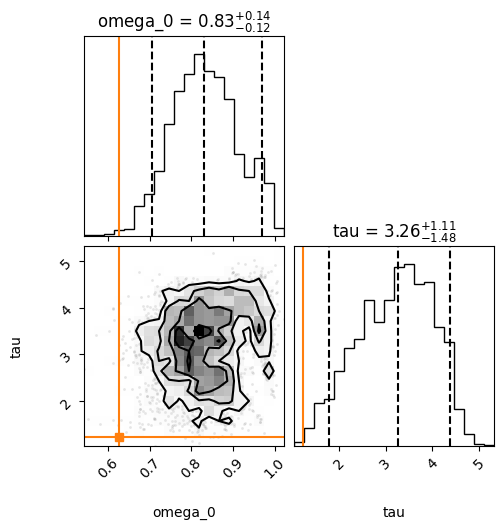

In [57]:
for idx, (_, theta_test, data_test, data_orig) in enumerate(test_data_loader):
    if idx % 1000 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0][0].reshape((1, 500)))
    live_plot_samples(samples.cpu().reshape(3000,2), theta_test[0][0].cpu()[...,0:2])
    plt.show()

# PP plot

15:04 bilby INFO    : Key: KS-test p-value
15:04 bilby INFO    : omega_0: 0.0
15:04 bilby INFO    : tau: 1.0991615011562185e-192
15:04 bilby INFO    : Combined p-value: 0.0


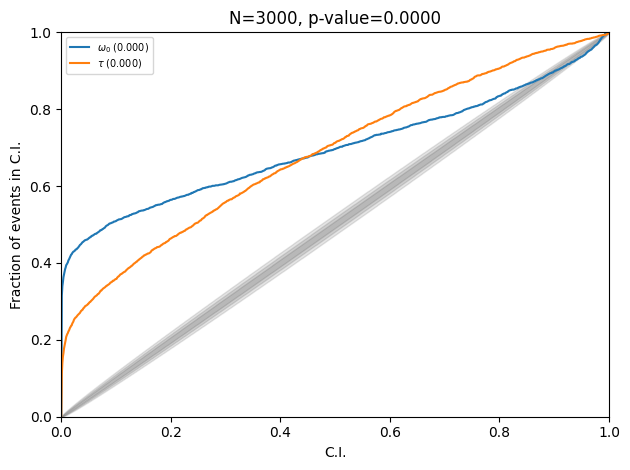

In [58]:
results = []
for idx, (_, theta_test, data_test, data_unshifted) in enumerate(test_data_loader):
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0][0].reshape((1, 500)))
    results.append(
        cast_as_bilby_result(samples.cpu().reshape(3000,2), theta_test[0][0].cpu()[...,0:2]))

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilby.result.make_pp_plot(results, save=False, keys=['omega_0', 'tau'])


In [59]:
%%time
results = []
for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0][0].reshape(1, 500))
    results.append(
        cast_as_bilby_result(samples.cpu().reshape(3000,2), theta_test[0][0].cpu())
    )

CPU times: user 46.3 s, sys: 10.8 s, total: 57.1 s
Wall time: 30.1 s


In [60]:
omega_std_vals = []
tau_std_vals = []
omega_0_vals = []
tau_vals = []

for result_s in results:
#     if result_s.posterior.std()['omega_0'] < 1:
    omega_std_vals.append(result_s.posterior.std()['omega_0'])
    tau_std_vals.append(result_s.posterior.std()['tau'])
    omega_0_vals.append(result_s.injection_parameters['omega_0'])
    tau_vals.append(result_s.injection_parameters['tau'])

## STD of $\omega_0$ and $\tau$

Text(0.5, 1.0, 'STD of Omega, Tau')

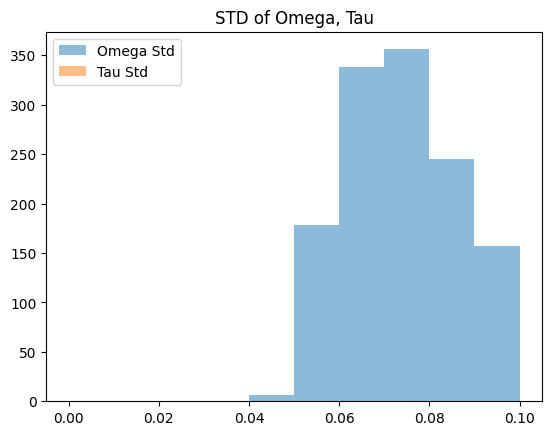

In [61]:
plt.hist(omega_std_vals, label='Omega Std', alpha = 0.5, range=(0,0.1))
plt.hist(tau_std_vals, label='Tau Std', alpha = 0.5, range=(0,0.1))
plt.legend()
plt.title("STD of Omega, Tau")

Text(0.5, 1.0, 'STD Scatter of Omega, Tau')

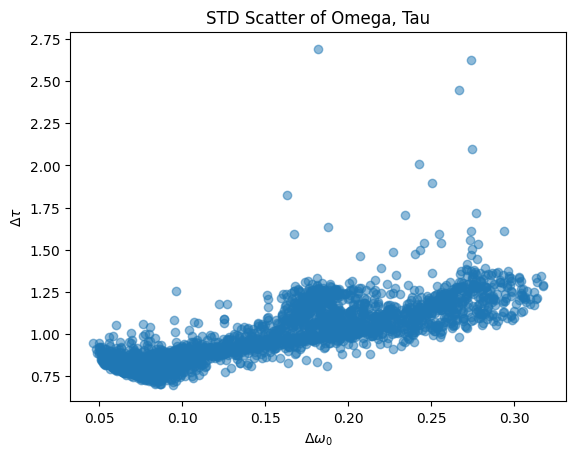

In [62]:
plt.scatter(omega_std_vals, tau_std_vals, alpha = 0.5)
# plt.xlim(0,0.6)
# plt.ylim(0,0.1)
plt.xlabel(r'$\Delta {\omega}_0$')
plt.ylabel(r'$\Delta \tau$')
plt.title("STD Scatter of Omega, Tau")

Text(0.5, 1.0, 'Omega Color Variation')

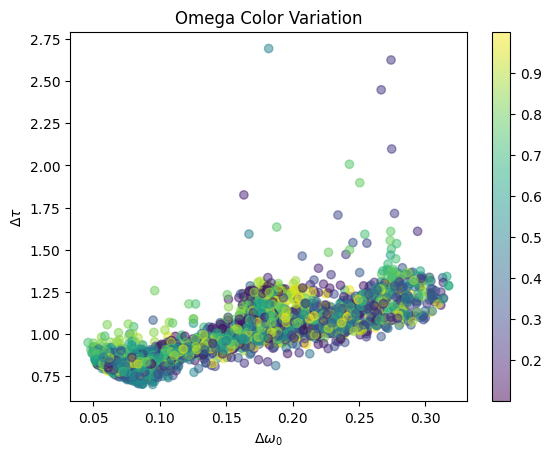

In [63]:
plt.scatter(omega_std_vals, tau_std_vals, c=omega_0_vals, cmap = 'viridis', alpha = 0.5)
# plt.xlim(0.0,0.6)
# plt.ylim(0,0.3)
plt.xlabel(r'$\Delta {\omega}_0$')
plt.ylabel(r'$\Delta \tau$')
plt.colorbar()
plt.title('Omega Color Variation')
# plt.scatter(df.x, df.y, s=200, c=df.z, cmap='gray')


Text(0.5, 1.0, 'Tau Color Variation')

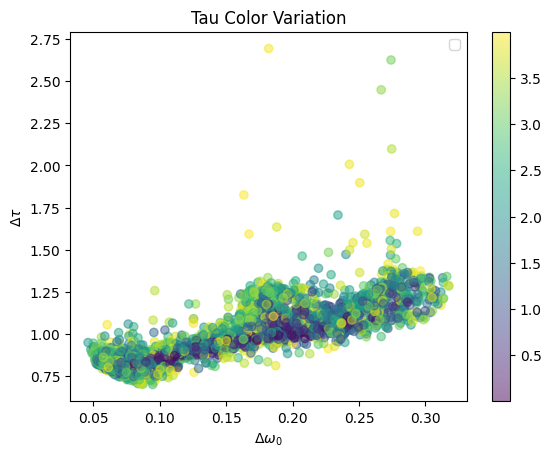

In [64]:
plt.scatter(omega_std_vals, tau_std_vals, c=tau_vals, cmap = 'viridis', alpha = 0.5)
# plt.xlim(0.0,0.6)
# plt.ylim(0,0.3)
plt.xlabel(r'$\Delta {\omega}_0$')
plt.ylabel(r'$\Delta \tau$')
plt.colorbar()
plt.legend()
plt.title('Tau Color Variation')

## Just $\omega_0$ and $\tau$

Text(0.5, 1.0, 'Omega, Tau values')

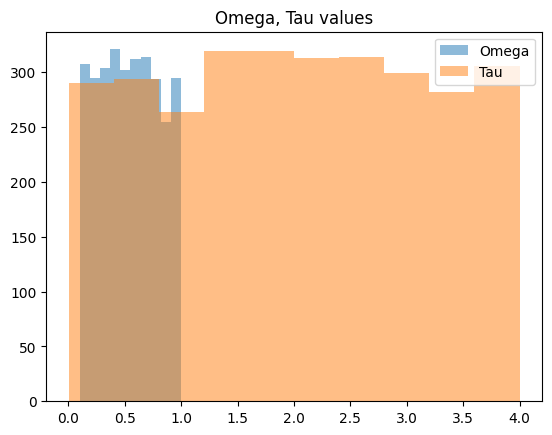

In [65]:
plt.hist(omega_0_vals, label='Omega', alpha = 0.5)
plt.hist(tau_vals, label='Tau', alpha = 0.5)
plt.legend()
plt.title("Omega, Tau values")

Text(0.5, 1.0, 'Omega, Tau values scatter')

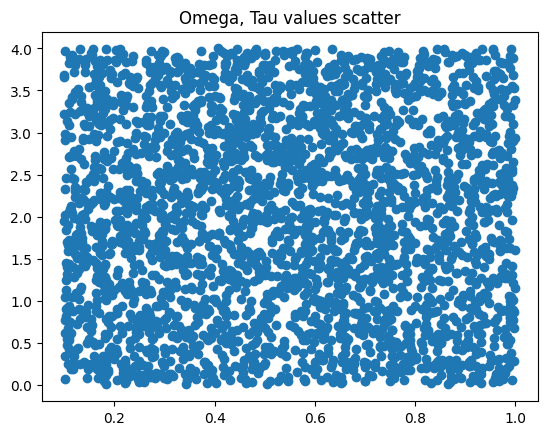

In [66]:
plt.scatter(omega_0_vals, tau_vals)
plt.title("Omega, Tau values scatter")